## Changes in Resting-State EEG Aperiodic 1/f Activity, Theta Oscillations, and Episodic Memory Performance in Healthy Adolescents and Older Adults

Authors: Anijärv, T.E., Campbell, A.J., Hermens, D.F., Lagopoulos, J. & Andrews, S.C.

Code created by Toomas Erik Anijärv in 08.02.2023

This notebook is a representation of EEG processing done for the publication with pre-processing shown with one participant, spectral analysis with two participants and final results (data visualisation) with the full dataset.

You are free to use this or any other code from this repository for your own projects and publications. Citation or reference to the repository is not required, but would be much appreciated (see more on README.md).

In [14]:
import mne, os, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections  import PathCollection
from matplotlib.lines  import Line2D
import seaborn as sns
import pingouin as pg
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.plts.periodic import plot_peak_params
from statannotations.Annotator import Annotator

# Set the current working directory to be the project main folder
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
plt.rc('axes', axisbelow=True)

import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.spectral_analysis as spectr

### PRE-PROCESSING

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'

exp_folder = 'LABS/Eyes Closed/T6'
exp_condition = 'EC_T6'

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signals to `mastoid`, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

In [ ]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
reference = 'average' # average as reference
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

# Set the directory in progress and find all BDF (raw EEG) files in there
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

In [ ]:
for i in range(len(file_dirs)):
    # Read in the raw EEG data
    raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                              stim_channel=stimulus_channel)

    # Set the right montage (Biosemi32) and set reference as average across all channels
    raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
             .set_eeg_reference(ref_channels=reference, verbose=True)

    # Find event markers for the start and end of resting state recordings
    events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
    tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]

    # Use the markers to crop to EEG signal to leave only the actual resting state
    cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
           'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                       eog_channels=eog_channels, plot_filt=False, savefig=False)

    # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt,subject_names[i],epo_duration=epochs_duration)

    # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
    #%matplotlib qt
    #epochs.plot(n_channels=32,n_epochs=1)

    # Try to create a directory and save the EEG file to that directory
    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
    except FileExistsError:
        pass

### SPECTRAL ANALYSIS

**Locating the EEG files in folders** by defining the experiment sub-folders (`exp_folder`), folder with clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During spectral analysis, all the clean EEG files are analysed and exported to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
clean_folder = 'Data/Clean/'
spectra_folder = 'Data/Spectra/'
results_folder = 'Results/'

exp_folder = ['LABS-LEISURE/Eyes Closed/LEISURE', 'LABS-LEISURE/Eyes Closed/LABS']
exp_condition = ['LEISURE', 'LABS']

**Spectral analysis** within this study includes estimating `Welch's power spectrum density (PSD)` for all the participants at five brain regions (i.e., `frontal`, `parietal`, `left-temporal`, `right-temporal` and `occipital`). The PSDs are fitted with `specparam` (`FOOOF`) model to estimate aperiodic 1/f-like component in the spectra which can be described with parameters `exponent` and `offset`. After that, the spectrum is flattened by substracting aperiodic component from the spectrum and within the given alpha band (`7-14 Hz`), a maximum power value, i.e. peak, is detected and its amplitude (i.e. `alpha power width`) and frequency (i.e. `alpha center frequency`) are exported. Finally, `absolute alpha band power` is calculated from the flattened spectrum by averaging PSD estimate within the center frequency and its bandwidth of 6 Hz (e.g., CF=10.4Hz -> alpha band=7.4-13.4Hz) and `relative alpha band power` is calculated by dividing the absolute band power by the broadband power (i.e., average PSD across all spectrum).

Welch's PSD is calculated for `1-30 Hz` frequency range using `2.5-second Hamming window (50% overlap)` and 39 times the window (97.5 seconds) zero-padding (for more interpolated frequency points when finding center frequency of the alpha peak).

The FOOOF (specparam) algorithm (version 1.0.0) was used to parameterize neural power spectra. Settings for the algorithm were set as: `peak width limits : 1-12 Hz`; `max number of peaks : infinite`; `minimum peak height : 0.225 uV^2`; `peak threshold : 2.0 uV^2`; and `aperiodic mode : fixed`. Power spectra were parameterized across the frequency range `1-30 Hz`. The aperiodic 1/f-like fit is described with the following function, where $S$ is aperiodic component, $b$ is `offset`, $F$ is vector of frequencies, and $e$ is `exponent`:

$S=b-log(F^e)$

The results are saved as Excel spreadsheets regionally to `results_folder/exp_folder/FOOOF`.

In [ ]:
### DEFINE ###
bands = {'Theta' : [4, 8]}
brain_regions = {'Left frontal' : ['AF3', 'F3', 'FC1'],
                 'Right frontal' : ['AF4', 'F4', 'FC2'],
                 'Left temporal' : ['F7', 'FC5', 'T7'],
                 'Right temporal' : ['F8', 'FC6', 'T8'],
                 'Left posterior' : ['CP5', 'P3', 'P7'],
                 'Right posterior' : ['CP6', 'P4', 'P8']}
flat_spectr_scale = 'linear'
plot_rich = True
savefig = True
savespectrum = True
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=3)
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float("inf"), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

spectrum_name = psd_params['method']+'_'+str(psd_params['fminmax'][0])+'-'+str(psd_params['fminmax'][1])+'Hz_WIN='+str(
                psd_params['window_duration'])+'s_'+psd_params['window']+'_OL='+str(psd_params['window_overlap']*
                100)+'%_ZP='+str(psd_params['zero_padding']*psd_params['window_duration'])+'s'

sns.set_palette('muted')
sns.set_style("whitegrid")

In [ ]:
# Loop through both experiment folders
for exp in range(len(exp_folder)):
    # Set the directory in progress and find all FIF (clean EEG) files in there
    dir_inprogress = os.path.join(clean_folder, exp_folder[exp])
    file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')
    arrange.create_results_folders(exp_folder=exp_folder[exp], results_folder=results_folder, fooof=True)

    if savespectrum == True:
        try:
            os.makedirs(os.path.join('{}/{}/{}'.format(spectra_folder, exp_folder[exp], spectrum_name)))
        except FileExistsError:
            pass
        try:
            os.makedirs(os.path.join('{}/{}/{}'.format(results_folder, exp_folder[exp], spectrum_name)))
        except FileExistsError:
            pass

    for i in range(len(file_dirs)):
        # Read in the clean EEG data
        epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                    verbose=False)
        
        # Calculate Welch's power spectrum density
        [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], method=psd_params['method'],
                                            fminmax=psd_params['fminmax'], window=psd_params['window'],
                                            window_duration=psd_params['window_duration'],
                                            window_overlap=psd_params['window_overlap'],
                                            zero_padding=psd_params['zero_padding'],
                                            verbose=True, plot=False)
        
        # Average all epochs and channels together -> (freq bins,) shape
        if i == 0:
            psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
        psds_allch[i] = psds.mean(axis=(0, 1))

        # Average all epochs together for each channel and also for each region
        psds = psds.mean(axis=(0))
        df_psds_ch = arrange.array_to_df(subject_names[i], epochs, psds).\
                             reset_index().drop(columns='Subject')
        df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).\
                                  reset_index().drop(columns='Subject')

        # Go through all regions of interest
        for region in df_psds_regions.columns:
            if i == 0:
                globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
                globals()["df_powerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)
                globals()["df_flatpowerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)

            psds_temp = df_psds_regions[region].to_numpy()

            # Fit the spectrum with FOOOF (specparam)
            fm = FOOOF(**fooof_params, verbose=True)
            fm.fit(freqs, psds_temp, psd_params['fminmax'])
                
            # Log-linear conversion based on the chosen amplitude scale
            if flat_spectr_scale == 'linear':
                flatten_spectrum = 10 ** fm._spectrum_flat
                flat_spectr_ylabel = 'Power (µV\u00b2/Hz)'
            elif flat_spectr_scale == 'log':
                flatten_spectrum = fm._spectrum_flat
                flat_spectr_ylabel = 'Log-normalised power (log\u2081\u2080[uV\u00b2/Hz])'

            # Find individual alpha band parameters
            abs_bp, rel_bp = spectr.find_bp(flatten_spectrum, freqs, bands['Theta'])

            # Set plot styles
            data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
            model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
            aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                                'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
            flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
            hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

            # Plot power spectrum model + aperiodic fit
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
            plot_spectrum(fm.freqs, fm.power_spectrum,
                        ax=axs[0], plot_style=None, **data_kwargs)
            plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                        ax=axs[0], plot_style=None, **model_kwargs)
            plot_spectrum(fm.freqs, fm._ap_fit,
                        ax=axs[0], plot_style=None, **aperiodic_kwargs)
            axs[0].set_xlim(psd_params['fminmax'])
            axs[0].grid(linewidth=0.2)
            axs[0].set_xlabel('Frequency (Hz)')
            #axs[0].set_ylabel('Log-normalised power (log\u2081\u2080[uV\u00b2/Hz])')
            axs[0].set_ylabel('Log-normalised power (log$_{10}$[µV\u00b2/Hz])')
            axs[0].set_title('Spectrum model fit')
            axs[0].legend()
            
            # Flattened spectrum plot (i.e., minus aperiodic fit)
            plot_spectrum_shading(fm.freqs, flatten_spectrum,
                        ax=axs[1], shades=bands['Theta'], shade_colors='green',
                        plot_style=None, **flat_kwargs)
            #axs[1].vlines(bands['Theta'], ymin=axs[1].get_ylim()[0], ymax=axs[1].get_ylim()[1])
            axs[1].set_xlim(psd_params['fminmax'])
            axs[1].grid(linewidth=0.2)
            axs[1].set_xlabel('Frequency (Hz)')
            axs[1].set_ylabel(flat_spectr_ylabel)
            axs[1].set_title('Flattened spectrum')
            #axs[1].legend()

            # If true, plot all the exported variables on the plots
            if plot_rich == True:
                axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                            '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                            (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
                axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                            '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                            (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
                axs[1].annotate('Absolute theta BP: '+str(np.round(abs_bp, 4))+'\nRelative theta BP: '+str(np.round(rel_bp, 4)),
                                (0.69, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
            
            plt.suptitle('{} region ({})'.format(region, subject_names[i]))
            plt.tight_layout()
            if savefig == True:
                plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_fooof.png'.format(results_folder, exp_folder[exp],
                                                                          exp_condition[exp], subject_names[i],
                                                                          region), dpi=300)
            plt.show()

            # Add model parameters to dataframe
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent']\
                                                            = fm.get_params('aperiodic_params','exponent')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset']\
                                                            = fm.get_params('aperiodic_params','offset')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.\
                            format(list(bands.keys())[0])] = abs_bp
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.\
                            format(list(bands.keys())[0])] = rel_bp
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2']\
                                                            = fm.get_params('r_squared')
            globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error']\
                                                            = fm.get_params('error')
            
            # Add the original and flattened power spectra to the dataframe
            globals()["df_powerspectra_"+region].loc[subject_names[i]] = fm.power_spectrum
            globals()["df_flatpowerspectra_"+region].loc[subject_names[i]] = flatten_spectrum

    # Export aperiodic data for all regions
    for region in df_psds_regions.columns:
        globals()["df_fooof_"+region].to_excel('{}/{}/FOOOF/{}_{}_fooof.xlsx'.format(results_folder,
                                                                                    exp_folder[exp],
                                                                                    exp_condition[exp],
                                                                                    region))
        display(globals()["df_fooof_"+region])

        if savespectrum == True:
            globals()["df_powerspectra_"+region].to_excel('{}/{}/{}/{}_powerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                    exp_folder[exp],
                                                                                                    spectrum_name,
                                                                                                    exp_condition[exp],
                                                                                                    region))
            globals()["df_flatpowerspectra_"+region].to_excel('{}/{}/{}/{}_flatpowerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                            exp_folder[exp],
                                                                                                            spectrum_name,
                                                                                                            exp_condition[exp],
                                                                                                            region))
            #display(globals()["df_powerspectra_"+region])
            #display(globals()["df_flatpowerspectra_"+region])

### PARTICIPANTS EXCLUSION & MASTER FILES

**Participants exclusion** is done firstly by reading all the previously exported data and adding them all into single dataframe. The participants are checked for set of criteria which if they do not match, `visual inspection of the model fit and alpha peak detection` is done. The criteria are the following: $error >= 0.1$, $R^2 <= 0.9$, $alpha$ $PW <= 0$, $alpha$ $absolute$ $power <= 0$, $alpha$ $relative$ $power <= 0$. After visual inspection of these participants particularly, `participants whose model fit is bad or there is no alpha peak are removed from the dataset`.

In [ ]:
### DEFINE ###
results_folder = 'Results/'
savefinal_folder = 'Results/LABS-LEISURE/'

exp_folder = ['LABS-LEISURE/Eyes Closed/LEISURE', 'LABS-LEISURE/Eyes Closed/LABS']
exp_condition = ['LEISURE', 'LABS']

freq_range = [1, 30]

spectra_folder = 'Data/Spectra/'
spectrum_name = 'welch_1-30Hz_WIN=2.5s_hamming_OL=50.0%_ZP=7.5s'

In [ ]:
# Read in aperiodic spectral analysis data for all groups and regions into one dataframe
df = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder[exp]+'/FOOOF',
                                                                 results_folder,
                                                                 condition_strsplit='_fooof')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Region'] = condition[reg].split('_', 1)[1]
        df_temp['Group'] = condition[reg].split('_', 1)[0]

        # Merge the new dataframe to the master one
        df = pd.concat([df, df_temp])

In [ ]:
# Read in all pure power spectras (original and flatten) for all groups and regions into one dataframe (for later grand average plots)
df_psd = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder[exp]+'/'+spectrum_name,
                                                                 spectra_folder,
                                                                 condition_strsplit='.')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Region'] = condition[reg].split('_', 2)[2]
        df_temp['Type'] = condition[reg].split('_', 2)[1]
        df_temp['Group'] = condition[reg].split('_', 2)[0]

        # Merge the new dataframe to the master one
        df_psd = pd.concat([df_psd, df_temp])

In [ ]:
# Display participants within the dataset who check for the set criteria
print('\n---\nError >= 0.1')
display(df[['Error', 'Region', 'Group']][df['Error']>=0.1].sort_index())
print('\n---\nR^2 <= 0.6')
display(df[['R_2', 'Region', 'Group']][df['R_2']<=0.6].sort_index())
# print('\n---\nTheta absolute power <= 0')
# display(df[['Theta absolute power', 'Region', 'Group']][df['Theta absolute power']<=0].sort_index())
# print('\n---\nTheta relative power <= 0')
# display(df[['Theta relative power', 'Region', 'Group']][df['Theta relative power']<=0].sort_index())
print('\n---\nExponent <= 0')
display(df[['Exponent', 'Region', 'Group']][df['Exponent']<=0].sort_index())

Removed participants are following

`HBA_0007_EC_T1` // bad model fit at LT (exp<=0) and RT (exp<=0)

`HBA_0009_EC_T1` // bad model fit at LT (exp<=0)

`HBA_0014_EC_T1` // bad model fit at RT (R2=0.58)

`HBA_0016_EC_T1` // bad model fit at LP (exp<=0), LT (exp<=0), RP (R2=0.03) and RT (R2=0.54)

`HBA_0070_EC_T1` // bad model fit at LT (R2=0.45)

`HBA_0093_EC_T1` // bad model fit at RT (R2=0.5) and RF (R2=0.55)

In [ ]:
# Participants chosen visually to be removed due to either bad model fit or alpha peak detected wrongly
bad_participants = ['HBA_0007_EC_T1', 'HBA_0009_EC_T1', 'HBA_0014_EC_T1', 'HBA_0016_EC_T1',
                    'HBA_0070_EC_T1', 'HBA_0093_EC_T1']

# Remove the bad participants from the results dataframe AND PSDs dataframe
df_wo_bads = df.drop(index=(bad_participants))
df_psd_wo_bads = df_psd.drop(index=(bad_participants))

# Export the master dataframes that do not have the "bad" participants
df_wo_bads.to_excel('{}/specparam_{}.xlsx'.format(savefinal_folder, str(exp_condition)))
df_psd_wo_bads.to_excel('{}/powerspectra_{}.xlsx'.format(savefinal_folder, str(exp_condition)))

**Data visualisation** includes plotting for each region 1) `aperiodic component of the spectra` in log-log scale and `model parameters` (i.e. exponent and offset); 2) `alpha absolute power`, `alpha relative power` and `alpha peak parameters` (i.e. center frequency and peak power).

In [ ]:
df_wo_bads

### DATA VISUALISATION & STATISTICS

In [5]:
bands = {'Theta' : [4, 8]}
brain_regions = {'Left frontal' : ['AF3', 'F3', 'FC1'],
                 'Right frontal' : ['AF4', 'F4', 'FC2'],
                 'Left temporal' : ['F7', 'FC5', 'T7'],
                 'Right temporal' : ['F8', 'FC6', 'T8'],
                 'Left posterior' : ['CP5', 'P3', 'P7'],
                 'Right posterior' : ['CP6', 'P4', 'P8']}

savefinal_folder = 'Results/LABS-LEISURE/'

exp_folder = ['LABS-LEISURE/Eyes Closed/LEISURE', 'LABS-LEISURE/Eyes Closed/LABS']
exp_condition = ['LEISURE', 'LABS']

savefig = True
freq_range = [1, 30]
plot_titles = False

sns.set_palette('muted')
sns.set_style("whitegrid")

Read in the master files of EEG parameters and PSDs + check for normal distribution for all four parameters.

In [6]:
# Read in the final datasets for the measures and PSDs
df_wo_bads = pd.read_excel('{}/specparam_{}-linear.xlsx'.format(savefinal_folder, str(exp_condition)), index_col=0)
df_psd_wo_bads = pd.read_excel('{}/powerspectra_{}-linear.xlsx'.format(savefinal_folder, str(exp_condition)), index_col=0)
df_demo_cog = pd.read_excel('{}/demo_PAL_{}.xlsx'.format(savefinal_folder, str(exp_condition)), index_col=0).set_index(['demographic I.D'])

# Get the sample size for both groups
print('Sample sizes:')
print('LEISURE =', int(len(df_wo_bads[df_wo_bads['Group']=='LEISURE'].index)/len(df_wo_bads['Region'].unique())))
print('LABS =', int(len(df_wo_bads[df_wo_bads['Group']=='LABS'].index)/len(df_wo_bads['Region'].unique())))

# Test for normality with Shapiro-Wilk test
measures = ['Exponent', 'Offset', 'Theta absolute power', 'Theta relative power']
df_normalities = pd.DataFrame()
for region in df_wo_bads['Region'].unique():
    df_wo_bads_reg = df_wo_bads[df_wo_bads['Region']==region]

    for measure in measures:
        df_normalities_temp = pg.normality(df_wo_bads_reg, dv=measure, group='Group', method='shapiro')
        df_normalities_temp['Measure'] = measure
        df_normalities_temp['Region'] = region
        
        df_normalities = pd.concat([df_normalities, df_normalities_temp])

exp_norm = df_normalities[df_normalities['Measure']=='Exponent']['normal']
off_norm = df_normalities[df_normalities['Measure']=='Offset']['normal']
abst_norm = df_normalities[df_normalities['Measure']=='Theta absolute power']['normal']
relt_norm = df_normalities[df_normalities['Measure']=='Theta relative power']['normal']

print('\nNormal distribution (Shapiro-Wilk):')
print('Exponent =', exp_norm.sum(), '/', exp_norm.count())
print('Offset =', off_norm.sum(), '/', off_norm.count())
print('Theta absolute power =', abst_norm.sum(), '/', abst_norm.count())
print('Theta relative power =', relt_norm.sum(), '/', relt_norm.count())

Sample sizes:
LEISURE = 81
LABS = 94

Normal distribution (Shapiro-Wilk):
Exponent = 11 / 12
Offset = 11 / 12
Theta absolute power = 0 / 12
Theta relative power = 0 / 12


In [7]:
# Add groups names to the demographics and PAL dataset
df_demo_cog.loc[['HBA' in s for s in df_demo_cog.index], 'Group'] = 'LEISURE'
df_demo_cog.loc[['LAB' in s for s in df_demo_cog.index], 'Group'] = 'LABS'

for i, group in enumerate(exp_condition):
    print('\n',group,'descriptives:')
    display(df_demo_cog[df_demo_cog['Group']==group].describe())


 LEISURE descriptives:


,demographic_age,demographic_gender_female,CANTAB_PALTEA28,CANTAB_PALTEA28_OA
count,81.000000,81.000000,81.000000,81.000000
mean,64.761998,0.802469,17.888889,17.888889
std,8.199661,0.400617,13.738632,13.738632
min,50.148560,0.000000,0.000000,0.000000
25%,59.282294,1.000000,10.000000,10.000000
50%,64.440724,1.000000,14.000000,14.000000
75%,71.386934,1.000000,20.000000,20.000000
max,84.041239,1.000000,57.000000,57.000000



 LABS descriptives:


,demographic_age,demographic_gender_female,CANTAB_PALTEA28,CANTAB_PALTEA28_OA
count,94.000000,94.000000,94.000000,94.000000
mean,13.273488,0.478723,6.638298,6.191489
std,0.540169,0.502226,6.958944,5.031677
min,12.386066,0.000000,0.000000,0.000000
25%,12.830000,0.000000,2.000000,2.000000
50%,13.256704,0.000000,6.000000,6.000000
75%,13.650271,1.000000,8.000000,8.000000
max,14.395653,1.000000,43.000000,22.000000


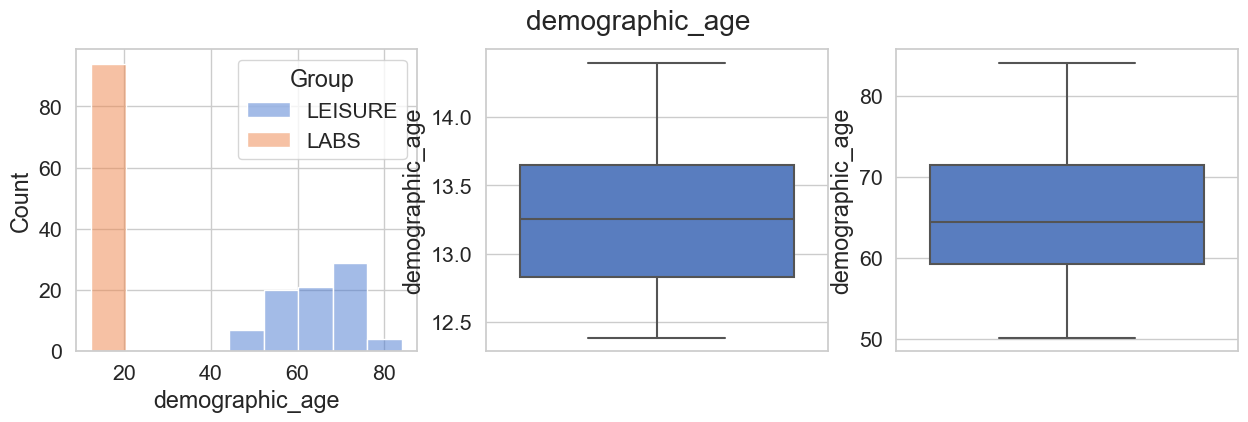

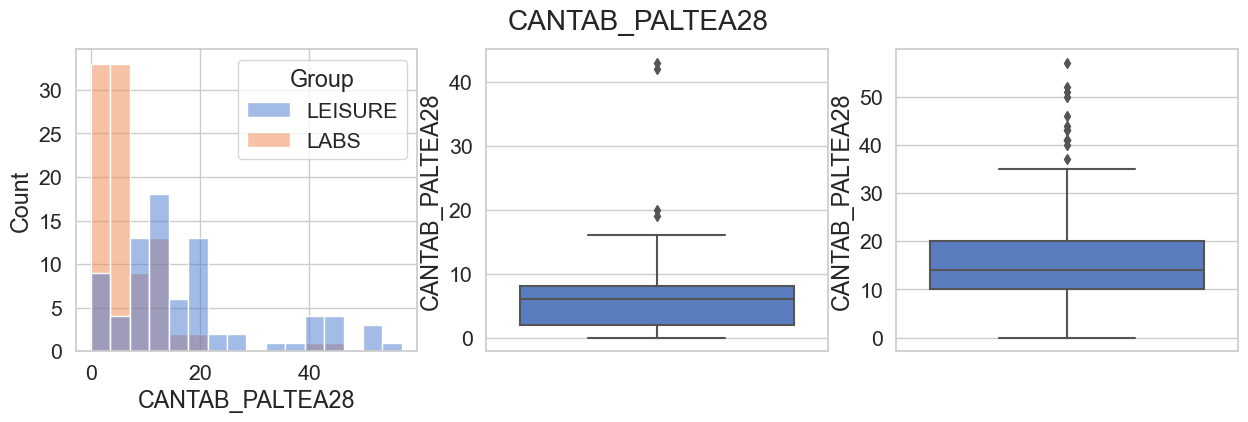

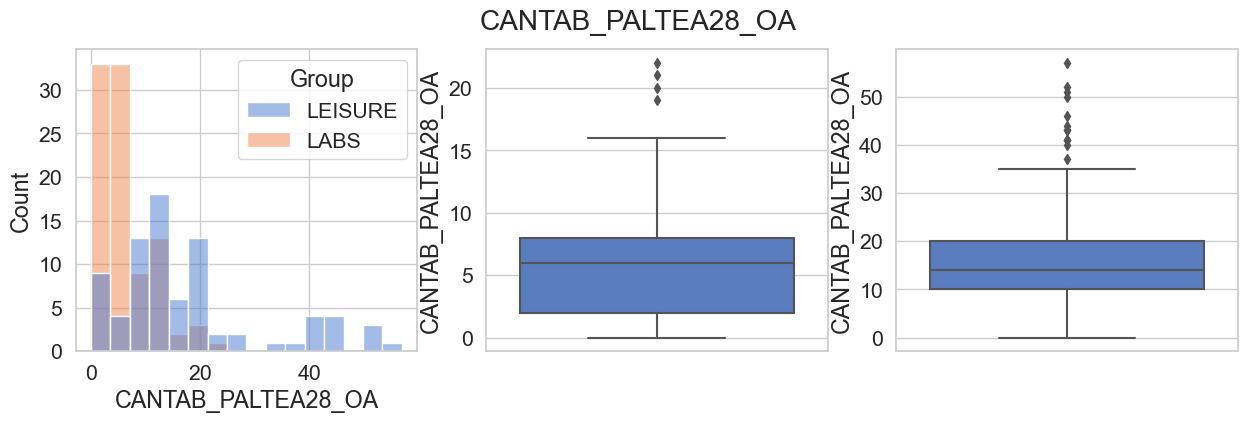

In [17]:
measures = df_demo_cog.drop(columns=['Group','demographic_gender_female']).columns

for measure in measures:
    sns.set_palette('muted')
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), dpi=100)
    sns.histplot(ax=axs[0], data=df_demo_cog, hue='Group', x=measure)
    sns.boxplot(ax=axs[1], data=df_demo_cog[df_demo_cog['Group']=='LABS'], y=measure)
    sns.boxplot(ax=axs[2], data=df_demo_cog[df_demo_cog['Group']=='LEISURE'], y=measure)
    plt.suptitle(measure)

In [9]:
df_demo_cog[df_demo_cog['CANTAB_PALTEA28']>=40]

,demographic_age,demographic_gender_female,CANTAB_PALTEA28,CANTAB_PALTEA28_OA,Group
demographic I.D,,,,,
HBA_0003_EC_T1,74.521585,1,51,51,LEISURE
HBA_0026_EC_T1,51.917860,1,44,44,LEISURE
HBA_0042_EC_T1,74.266797,1,43,43,LEISURE
HBA_0058_EC_T1,74.710303,1,41,41,LEISURE
HBA_0059_EC_T1,79.107551,0,52,52,LEISURE
HBA_0071_EC_T1,76.145151,1,57,57,LEISURE
HBA_0082_EC_T1,75.800415,0,40,40,LEISURE
HBA_0094_EC_T1,52.309135,1,41,41,LEISURE
HBA_0097_EC_T1,55.405305,1,43,43,LEISURE


In [10]:
df_wo_bads.loc['LAB_2452_04_EC']

,Exponent,Offset,Theta absolute power,Theta relative power,R_2,Error,Region,Group
LAB_2452_04_EC,1.675213,1.447988,1.328644,1.038788,0.981720,0.059657,Left frontal,LABS
LAB_2452_04_EC,1.576157,1.430029,1.502357,0.894495,0.993708,0.034697,Left posterior,LABS
LAB_2452_04_EC,1.354905,1.465943,0.885813,0.835306,0.957666,0.078220,Left temporal,LABS
LAB_2452_04_EC,1.594179,1.394262,1.027043,0.898417,0.981545,0.056462,Right frontal,LABS
LAB_2452_04_EC,1.582376,1.450915,2.242670,1.228937,0.992338,0.041529,Right posterior,LABS
LAB_2452_04_EC,1.102449,1.135572,1.117016,0.969085,0.975307,0.054817,Right temporal,LABS


**Aperiodic activity** plots

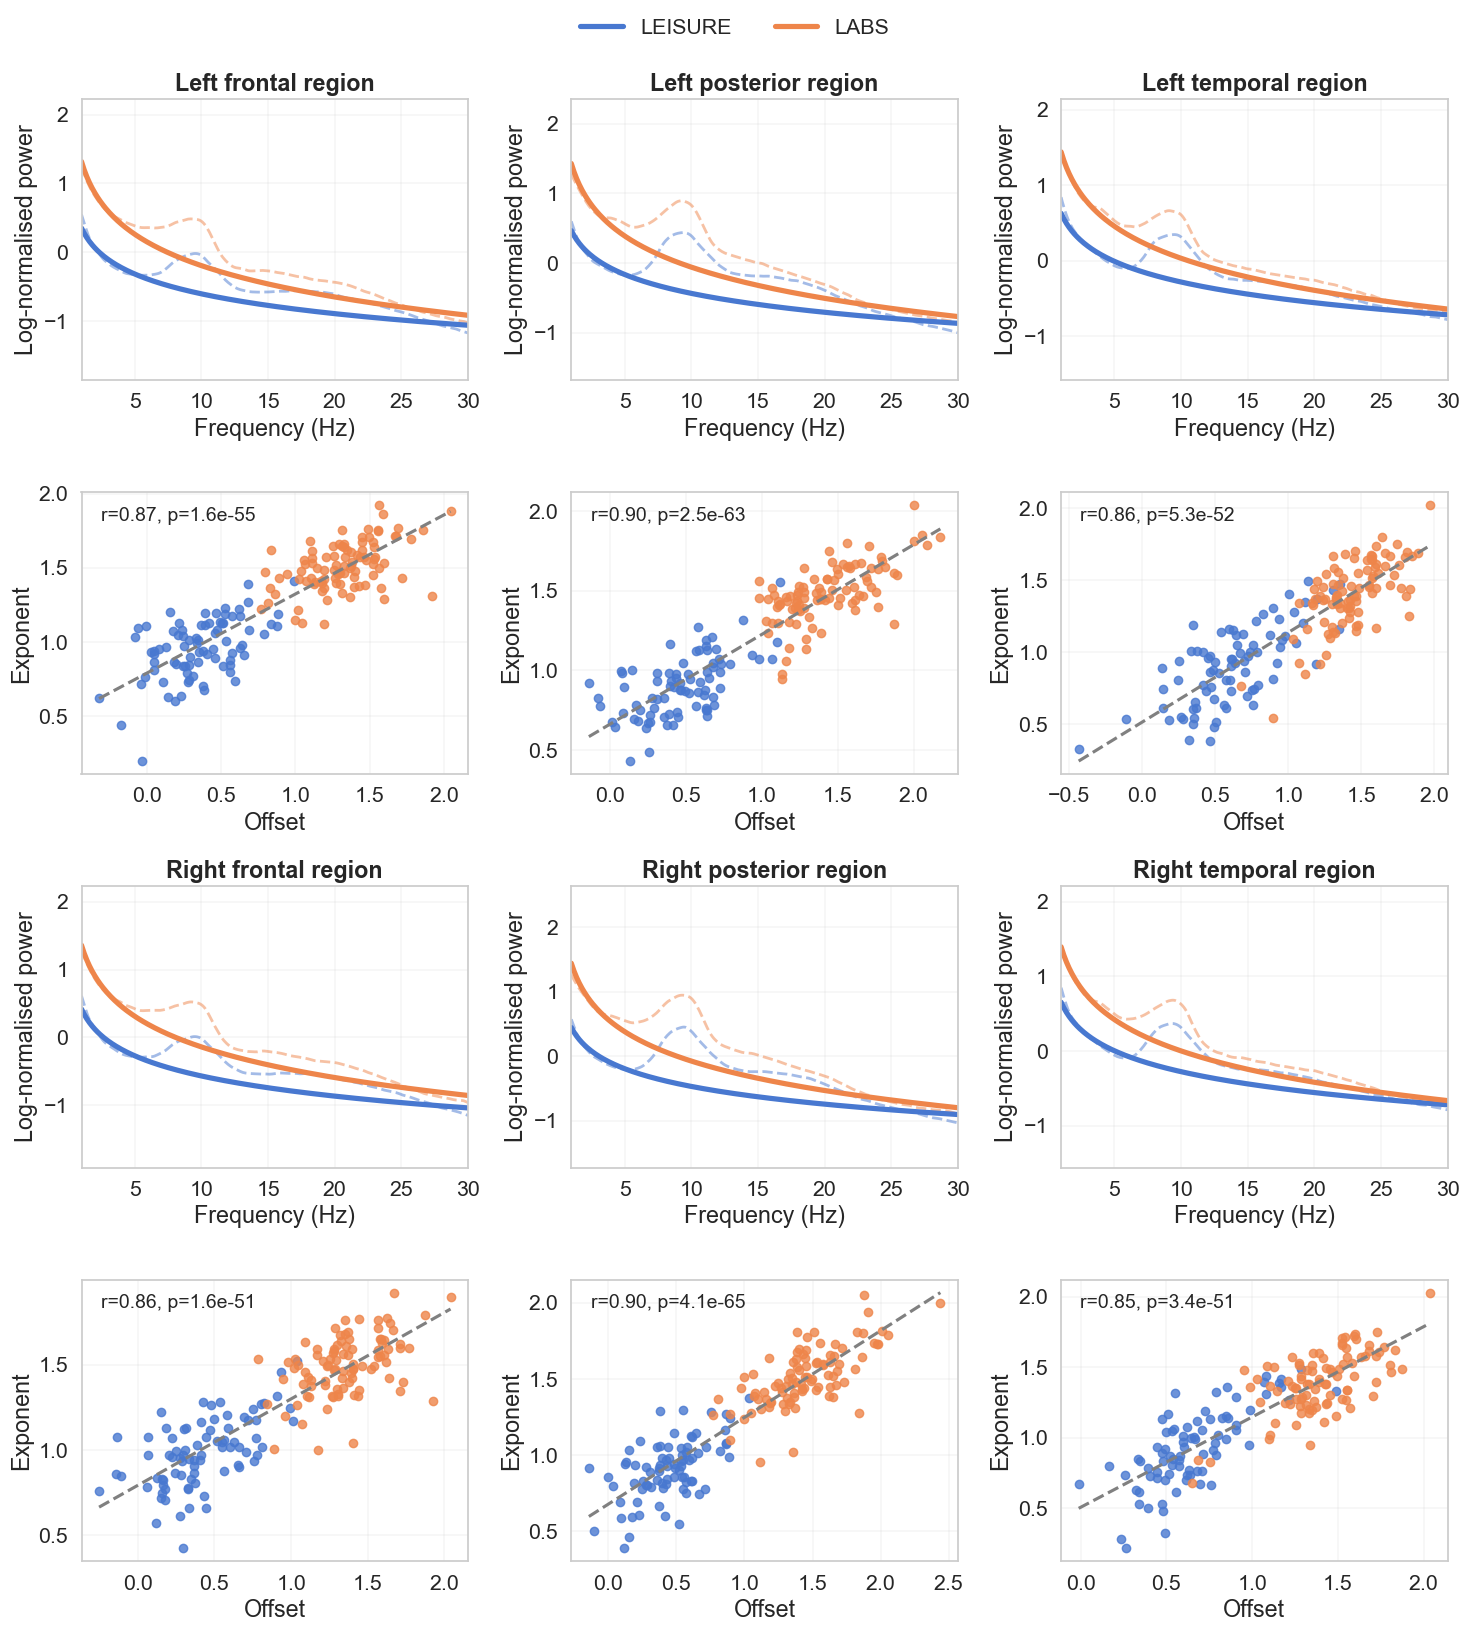

,n,r,CI95%,p-val,BF10,power,Group,Region
pearson,94,0.468362,"[0.29, 0.61]",1.931138e-06,9007.936,0.998183,LABS,Right frontal
pearson,94,0.504448,"[0.34, 0.64]",2.172043e-07,7.155e+04,0.999612,LABS,Left frontal
pearson,81,0.537924,"[0.36, 0.68]",2.232702e-07,7.26e+04,0.999635,LEISURE,Left frontal
pearson,81,0.568660,"[0.4, 0.7]",3.055440e-08,4.806e+05,0.999919,LEISURE,Right posterior
pearson,81,0.581121,"[0.42, 0.71]",1.285702e-08,1.096e+06,0.999959,LEISURE,Right frontal
pearson,81,0.590593,"[0.43, 0.72]",6.496581e-09,2.103e+06,0.999976,LEISURE,Left posterior
pearson,94,0.644230,"[0.51, 0.75]",2.463777e-12,3.963e+09,1.000000,LABS,Left posterior
pearson,94,0.656491,"[0.52, 0.76]",6.785759e-13,1.376e+10,1.000000,LABS,Right temporal
pearson,94,0.678887,"[0.55, 0.77]",5.483590e-14,1.564e+11,1.000000,LABS,Left temporal
pearson,94,0.681324,"[0.56, 0.78]",4.114921e-14,2.065e+11,1.000000,LABS,Right posterior


In [18]:
aps_LEISURE = [None]*len(brain_regions)
aps_LABS = [None]*len(brain_regions)
df_aps_corr = pd.DataFrame()

# Set plot styles
aperiodicfit_kwargs = {'linewidth' : 1.25, 'alpha' : 0}
aperiodicfit_psd_kwargs = {'linewidth' : 2, 'alpha' : 0.5, 'linestyle' : '--'}

sns.set_context('notebook', font_scale=1.4)
sns.set_palette('muted')
sns.set_style("whitegrid")
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 16), dpi=100)
for i, region in enumerate(df_wo_bads['Region'].unique()):
    # Choose only original PSDs and only the region of interest
    df_psds = df_psd_wo_bads[df_psd_wo_bads['Type']=='powerspectra']
    df_psds = df_psds[df_psds['Region']==region]

    # Create regional original PSD files for both groups
    df_psds_LEISURE = df_psds[df_psds['Group']=='LEISURE'].drop(columns=['Group', 'Type', 'Region'])
    df_psds_LABS = df_psds[df_psds['Group']=='LABS'].drop(columns=['Group', 'Type', 'Region'])

    # Grand average PSDs for both groups
    freqs = df_psds_LEISURE.columns.to_numpy()
    psd_mean_LEISURE = df_psds_LEISURE.mean(axis=0)
    psd_mean_LABS = df_psds_LABS.mean(axis=0)

    # Take only the region of interest for the aperiodic parameters in the df
    df_aps_reg = df_wo_bads[['Offset','Exponent','Group']][df_wo_bads['Region']==region]

    # Find Pearson's correlation between aperiodic parameters within groups and total sample size
    for group in exp_condition:
        df_aps_corr_temp = pg.corr(df_aps_reg[df_aps_reg['Group']==group]['Offset'],
                                   df_aps_reg[df_aps_reg['Group']==group]['Exponent'])
        df_aps_corr_temp['Group'] = group
        df_aps_corr_temp['Region'] = region
        df_aps_corr = pd.concat([df_aps_corr, df_aps_corr_temp])
    df_aps_corr_total_temp = pg.corr(df_aps_reg['Offset'], df_aps_reg['Exponent'])
    df_aps_corr_total_temp['Group'] = 'both'
    df_aps_corr_total_temp['Region'] = region
    df_aps_corr = pd.concat([df_aps_corr, df_aps_corr_total_temp])

    # Convert the offset and exponent for both groups to 2D arrays
    aps_LEISURE[i] = df_aps_reg[df_aps_reg['Group']=='LEISURE'].drop(columns='Group').values
    aps_LABS[i] = df_aps_reg[df_aps_reg['Group']=='LABS'].drop(columns='Group').values

    # Set the row and column for the subplots
    row=0
    col=i
    if col>=3:
        col-=3
        row+=2
    
    # Plot the aperiodic component with the original PSD
    plot_spectrum(freqs, psd_mean_LEISURE, ax=axs[row][col],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_spectrum(freqs, psd_mean_LABS, ax=axs[row][col],
                  plot_style=None, **aperiodicfit_psd_kwargs)
    plot_aperiodic_fits([aps_LEISURE[i], aps_LABS[i]], log_freqs=False,
                        ax=axs[row][col], freq_range=freq_range, plot_style=None,
                        labels=exp_condition, **aperiodicfit_kwargs)
    axs[row][col].grid(linewidth=0.2)
    axs[row][col].set_xlabel('Frequency (Hz)')
    axs[row][col].set_ylabel('Log-normalised power')
    #axs[row][col].legend()
    axs[row][col].set_title('{} region'.format(region), fontweight='bold')

    # Plot the aperiodic component parameters (exponent and offset)
    sns.regplot(ax=axs[row+1][col], data=df_aps_reg[df_aps_reg['Group']=='LEISURE'], x='Offset', y='Exponent',
                fit_reg=False, ci=None)
    sns.regplot(ax=axs[row+1][col], data=df_aps_reg[df_aps_reg['Group']=='LABS'], x='Offset', y='Exponent',
                fit_reg=False, ci=None)
    sns.regplot(ax=axs[row+1][col], data=df_aps_reg, x='Offset', y='Exponent', scatter=False,
                ci=None, color='gray', line_kws=dict(linestyle='--'))
    axs[row+1][col].grid(linewidth=0.2)
    axs[row+1][col].set_xlabel('Offset')
    axs[row+1][col].set_ylabel('Exponent')

    rval = float(df_aps_corr_total_temp['r'])
    pval = float(df_aps_corr_total_temp['p-val'])
    axs[row+1][col].text(.05, .9, f'r={rval:.2f}, p={pval:.2g}', transform=axs[row+1][col].transAxes,
                         fontdict=dict(fontsize='small'))
    plt.tight_layout()

#axs[row+1][col].legend(exp_condition, loc='upper center', bbox_to_anchor=(-1.35,4.55,1,1), frameon=False, ncol=2)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2], loc='upper center', bbox_to_anchor=(0,0.03,1,1), frameon=False, ncol=2)

if savefig == True:
    plt.savefig(fname='{}/aperiodic_plot.png'.format(savefinal_folder, dpi=300))
plt.show()

df_aps_corr = df_aps_corr.sort_values(by=['r'])
display(df_aps_corr)

In [ ]:
# measure = 'Exponent'
# post_hoc = 'Bonferroni'

# # Run stats for all the regions
# df_stats = pd.DataFrame()
# for i, region in enumerate(df_aps['Region'].unique()):
#     # Do Welch's t-test test (parametric, independent groups but unequal sample sizes) between two groups
#     df_aps_reg = df_aps[df_aps['Region']==region].drop(columns=['Region'])
#     stats = pg.ttest(df_aps_reg[df_aps_reg['Group']==exp_condition[0]][measure],
#                      df_aps_reg[df_aps_reg['Group']==exp_condition[1]][measure])

#     # Apply Bonferroni post-hoc multiple comparisons correction
#     if post_hoc == 'Bonferroni':
#         stats['p-val'] = stats['p-val']*len(df_aps['Region'].unique())
#         stats['Post-hoc'] = post_hoc
#     else:
#         stats['Post-hoc'] = 'N/A'
    
#     stats['Groups'] = str(exp_condition)
#     stats['Region'] = region
#     stats['Measure'] = measure

#     df_stats = pd.concat([df_stats, stats])
# display(df_stats)

In [19]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                    break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,Post-hoc,Groups,Region,Measure
T-test,-19.609130,152.452571,two-sided,9.494879e-43,"[-0.61, -0.5]",3.022440,1.519e+42,1.0,Bonferroni,"['LEISURE', 'LABS']",Left frontal,Exponent
T-test,-20.484566,166.782911,two-sided,1.272694e-46,"[-0.64, -0.53]",3.115660,2.833e+44,1.0,Bonferroni,"['LEISURE', 'LABS']",Left posterior,Exponent
T-test,-12.760801,160.273106,two-sided,2.100400e-25,"[-0.58, -0.42]",1.954008,2.374e+23,1.0,Bonferroni,"['LEISURE', 'LABS']",Left temporal,Exponent
T-test,-17.663541,159.745790,two-sided,1.269246e-38,"[-0.57, -0.45]",2.706037,1.006e+37,1.0,Bonferroni,"['LEISURE', 'LABS']",Right frontal,Exponent
T-test,-20.547735,168.781470,two-sided,5.100785e-47,"[-0.66, -0.55]",3.117058,4.116e+44,1.0,Bonferroni,"['LEISURE', 'LABS']",Right posterior,Exponent
T-test,-12.150459,152.002443,two-sided,2.179853e-23,"[-0.54, -0.39]",1.873463,4.599e+21,1.0,Bonferroni,"['LEISURE', 'LABS']",Right temporal,Exponent


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left posterior_LEISURE vs. Left posterior_LABS: Custom statistical test, P_val:1.273e-46
Left frontal_LEISURE vs. Left frontal_LABS: Custom statistical test, P_val:9.495e-43
Left temporal_LEISURE vs. Left temporal_LABS: Custom statistical test, P_val:2.100e-25
Right frontal_LEISURE vs. Right frontal_LABS: Custom statistical test, P_val:1.269e-38
Right posterior_LEISURE vs. Right posterior_LABS: Custom statistical test, P_val:5.101e-47
Right temporal_LEISURE vs. Right temporal_LABS: Custom statistical test, P_val:2.180e-23


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,Post-hoc,Groups,Region,Measure
T-test,-24.966928,168.212470,two-sided,1.110962e-57,"[-1.04, -0.89]",3.790460,2.826e+55,1.0,Bonferroni,"['LEISURE', 'LABS']",Left frontal,Offset
T-test,-23.265992,170.546606,two-sided,5.082821e-54,"[-1.04, -0.88]",3.519355,2.526e+51,1.0,Bonferroni,"['LEISURE', 'LABS']",Left posterior,Offset
T-test,-18.834261,140.032594,two-sided,1.979774e-39,"[-0.9, -0.73]",2.929921,1.38e+40,1.0,Bonferroni,"['LEISURE', 'LABS']",Left temporal,Offset
T-test,-23.651820,160.479804,two-sided,2.122007e-53,"[-1.02, -0.86]",3.621018,2.159e+52,1.0,Bonferroni,"['LEISURE', 'LABS']",Right frontal,Offset
T-test,-24.448042,172.313229,two-sided,3.962742e-57,"[-1.08, -0.92]",3.648675,1.707e+54,1.0,Bonferroni,"['LEISURE', 'LABS']",Right posterior,Offset
T-test,-18.826910,163.549055,two-sided,5.136493e-42,"[-0.82, -0.67]",2.873806,1.32e+40,1.0,Bonferroni,"['LEISURE', 'LABS']",Right temporal,Offset


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left posterior_LEISURE vs. Left posterior_LABS: Custom statistical test, P_val:5.083e-54
Left frontal_LEISURE vs. Left frontal_LABS: Custom statistical test, P_val:1.111e-57
Left temporal_LEISURE vs. Left temporal_LABS: Custom statistical test, P_val:1.980e-39
Right frontal_LEISURE vs. Right frontal_LABS: Custom statistical test, P_val:2.122e-53
Right posterior_LEISURE vs. Right posterior_LABS: Custom statistical test, P_val:3.963e-57
Right temporal_LEISURE vs. Right temporal_LABS: Custom statistical test, P_val:5.136e-42


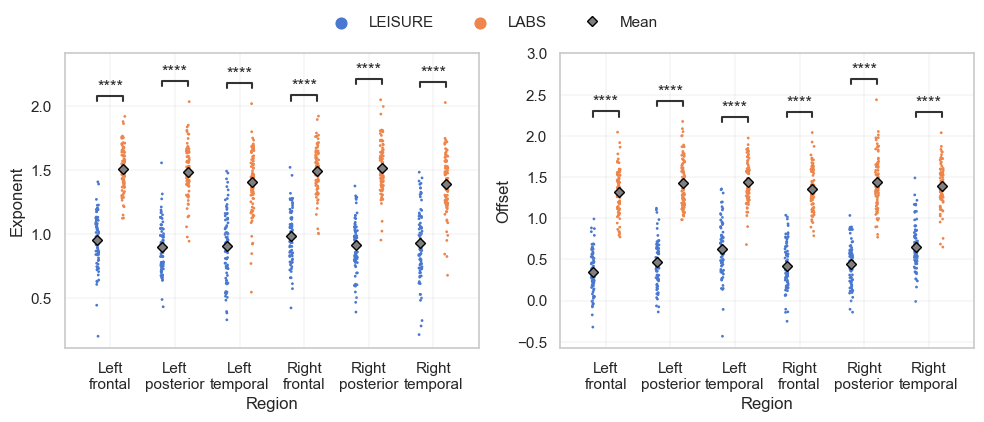

In [26]:
sns.set_context('notebook')
sns.set_palette('muted')
sns.set_style("whitegrid")
swarm_kwargs = {'edgecolor' : 'gray', 'size' : 2, 'linewidth' : 0, 'alpha' : 1}
point_kwargs = {'markers' : ['o', 'o'], 'linestyles' : [' ', ' '], 'errwidth' : 2,
                'capsize' : 0.1}
meanprop_kwargs = {'marker' : 'D', 'markeredgecolor' : 'black', 'markersize' : 5,
                   'markerfacecolor' : 'gray', 'label' : 'Mean'}

df_aps = df_wo_bads[['Exponent', 'Offset', 'Region', 'Group']]
measures = ['Exponent', 'Offset']
post_hoc = 'Bonferroni'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
for i, ap in enumerate(measures):
    # Run stats for all the regions // MAKE THIS STATS FUNCTION !!!!
    df_stats = pd.DataFrame()
    for j, region in enumerate(df_aps['Region'].unique()): # enumerate is not necessary!
        # Do Welch's t-test test (parametric, independent groups but unequal sample sizes) between two groups
        df_aps_reg = df_aps[df_aps['Region']==region].drop(columns=['Region'])
        stats = pg.ttest(df_aps_reg[df_aps_reg['Group']==exp_condition[0]][ap],
                        df_aps_reg[df_aps_reg['Group']==exp_condition[1]][ap])

        # Apply Bonferroni post-hoc multiple comparisons correction
        if post_hoc == 'Bonferroni':
            stats['p-val'] = stats['p-val']*len(df_aps['Region'].unique())
            stats['Post-hoc'] = post_hoc
        else:
            stats['Post-hoc'] = 'N/A'
        
        stats['Groups'] = str(exp_condition)
        stats['Region'] = region
        stats['Measure'] = ap

        df_stats = pd.concat([df_stats, stats])
    display(df_stats)
    
    sns.boxplot(ax=axs[i], data=df_aps, x='Region', y=ap, hue='Group',
                showmeans=True, meanprops=meanprop_kwargs, palette='muted',
                medianprops={'visible': False}, whiskerprops={'visible': False},
                showfliers=False, showbox=False, showcaps=False)
    sns.stripplot(ax=axs[i], data=df_aps, x='Region', y=ap, hue='Group',
                  dodge=True, jitter=0.05, zorder=0, **swarm_kwargs)
    axs[i].set_yscale('linear')
    axs[i].grid(linewidth=0.2)
    axs[i].set_xlabel('Region')
    axs[i].set_ylabel(ap)
    pairs=[
        (('Left frontal', 'LEISURE'), ('Left frontal', 'LABS')),
        (('Left posterior', 'LEISURE'), ('Left posterior', 'LABS')),
        (('Left temporal', 'LEISURE'), ('Left temporal', 'LABS')),
        (('Right frontal', 'LEISURE'), ('Right frontal', 'LABS')),
        (('Right posterior', 'LEISURE'), ('Right posterior', 'LABS')),
        (('Right temporal', 'LEISURE'), ('Right temporal', 'LABS'))]
    annotator = Annotator(axs[i], pairs=pairs, data=df_aps, x='Region', y=ap, hue='Group',
                            plot="boxplot")\
                    .configure(test=None, text_format='star',loc='inside', verbose=1)\
                    .set_pvalues(pvalues=df_stats['p-val']).annotate()
    wrap_labels(axs[i], 10)
    axs[i].get_legend().remove()

plt.tight_layout()
handles, _ = axs[i].get_legend_handles_labels()
new_handles = [h for h in handles if isinstance(h, PathCollection)] + [h for h in handles if isinstance(h, Line2D)][:1]
fig.legend(handles=new_handles, loc='upper center', bbox_to_anchor=(0,0.07,1,1), frameon=False, ncol=3)

if savefig == True:
    plt.savefig(fname='{}/exponent_offset.png'.format(savefinal_folder), dpi=300)
plt.show()

**Theta absolute band power** plot

,U-val,alternative,p-val,RBC,CLES,Post-hoc,Groups,Region,Measure
MWU,2291.0,two-sided,0.000035,0.398214,0.300893,Bonferroni,"['LEISURE', 'LABS']",Left frontal,Theta absolute power
MWU,2755.0,two-sided,0.009912,0.276333,0.361833,Bonferroni,"['LEISURE', 'LABS']",Left posterior,Theta absolute power
MWU,2903.0,two-sided,0.041145,0.237457,0.381271,Bonferroni,"['LEISURE', 'LABS']",Left temporal,Theta absolute power
MWU,2425.0,two-sided,0.000214,0.363015,0.318492,Bonferroni,"['LEISURE', 'LABS']",Right frontal,Theta absolute power
MWU,2518.0,two-sided,0.000692,0.338587,0.330707,Bonferroni,"['LEISURE', 'LABS']",Right posterior,Theta absolute power
MWU,2893.0,two-sided,0.037587,0.240084,0.379958,Bonferroni,"['LEISURE', 'LABS']",Right temporal,Theta absolute power


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left posterior_LEISURE vs. Left posterior_LABS: Custom statistical test, P_val:9.912e-03
Left frontal_LEISURE vs. Left frontal_LABS: Custom statistical test, P_val:3.455e-05
Left temporal_LEISURE vs. Left temporal_LABS: Custom statistical test, P_val:4.115e-02
Right frontal_LEISURE vs. Right frontal_LABS: Custom statistical test, P_val:2.138e-04
Right posterior_LEISURE vs. Right posterior_LABS: Custom statistical test, P_val:6.922e-04
Right temporal_LEISURE vs. Right temporal_LABS: Custom statistical test, P_val:3.759e-02


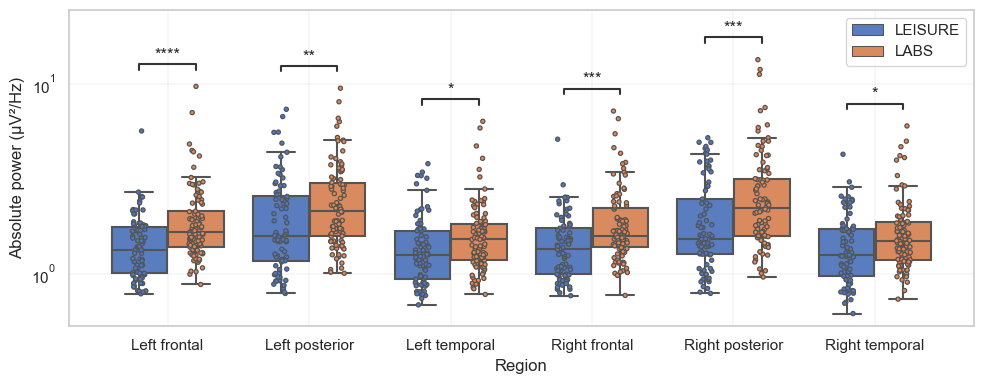

In [22]:
post_hoc = 'Bonferroni'
measure = 'Theta absolute power'

# Create a dataframe for the measure of interest
df_powers = df_wo_bads[[measure, 'Region', 'Group']]

# Run stats for all the regions
df_stats = pd.DataFrame()
for i, region in enumerate(df_wo_bads['Region'].unique()):
    # Do Mann-Whitney U test (non-parametric, independent groups) between two groups
    df_powers_reg = df_powers[df_powers['Region']==region].drop(columns=['Region'])
    stats = pg.mwu(df_powers_reg[df_powers_reg['Group']==exp_condition[0]][measure],
                   df_powers_reg[df_powers_reg['Group']==exp_condition[1]][measure])

    # Apply Bonferroni post-hoc multiple comparisons correction
    if post_hoc == 'Bonferroni':
        stats['p-val'] = stats['p-val']*len(df_wo_bads['Region'].unique())
        stats['Post-hoc'] = post_hoc
    else:
        stats['Post-hoc'] = 'N/A'
    
    stats['Groups'] = str(exp_condition)
    stats['Region'] = region
    stats['Measure'] = measure

    df_stats = pd.concat([df_stats, stats])
display(df_stats)

swarm_kwargs = {'edgecolor' : 'gray', 'size' : 3, 'linewidth' : 0.9}
sns.set_context('notebook')
sns.set_palette('muted')
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
sns.boxplot(ax=axs, data=df_powers,
            x='Region', y=measure, hue='Group', showfliers=False,
            flierprops=dict(markerfacecolor = '0.5', markersize = 1))
sns.stripplot(ax=axs, data=df_powers, x='Region', y=measure, hue='Group',
              dodge=True, **swarm_kwargs)
axs.set_yscale('log')
axs.grid(linewidth=0.2)
axs.set_xlabel('Region')
axs.set_ylabel('Absolute power (µV\u00b2/Hz)')
pairs=[
    (('Left frontal', 'LEISURE'), ('Left frontal', 'LABS')),
    (('Left posterior', 'LEISURE'), ('Left posterior', 'LABS')),
    (('Left temporal', 'LEISURE'), ('Left temporal', 'LABS')),
    (('Right frontal', 'LEISURE'), ('Right frontal', 'LABS')),
    (('Right posterior', 'LEISURE'), ('Right posterior', 'LABS')),
    (('Right temporal', 'LEISURE'), ('Right temporal', 'LABS'))]
annotator = Annotator(axs, pairs=pairs, data=df_powers, x='Region', y=measure, hue='Group',
                          plot="boxplot")\
                .configure(test=None, text_format='star',loc='inside', verbose=1)\
                .set_pvalues(pvalues=df_stats['p-val']).annotate()

if plot_titles==True: (axs.set_title('Theta absolute band power'))
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles[0:2], labels[0:2])
plt.tight_layout()
if savefig == True:
    plt.savefig(fname='{}/absolute_theta.png'.format(savefinal_folder), dpi=300)
plt.show()

**Theta relative band power** plot

,U-val,alternative,p-val,RBC,CLES,Post-hoc,Groups,Region,Measure
MWU,2093.0,two-sided,0.000002,0.450223,0.274888,Bonferroni,"['LEISURE', 'LABS']",Left frontal,Theta relative power
MWU,2434.0,two-sided,0.000240,0.360651,0.319674,Bonferroni,"['LEISURE', 'LABS']",Left posterior,Theta relative power
MWU,2465.0,two-sided,0.000358,0.352509,0.323746,Bonferroni,"['LEISURE', 'LABS']",Left temporal,Theta relative power
MWU,2119.0,two-sided,0.000003,0.443394,0.278303,Bonferroni,"['LEISURE', 'LABS']",Right frontal,Theta relative power
MWU,2600.0,two-sided,0.001834,0.317048,0.341476,Bonferroni,"['LEISURE', 'LABS']",Right posterior,Theta relative power
MWU,2523.0,two-sided,0.000736,0.337273,0.331363,Bonferroni,"['LEISURE', 'LABS']",Right temporal,Theta relative power


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left posterior_LEISURE vs. Left posterior_LABS: Custom statistical test, P_val:2.403e-04
Left frontal_LEISURE vs. Left frontal_LABS: Custom statistical test, P_val:1.761e-06
Left temporal_LEISURE vs. Left temporal_LABS: Custom statistical test, P_val:3.576e-04
Right frontal_LEISURE vs. Right frontal_LABS: Custom statistical test, P_val:2.654e-06
Right posterior_LEISURE vs. Right posterior_LABS: Custom statistical test, P_val:1.834e-03
Right temporal_LEISURE vs. Right temporal_LABS: Custom statistical test, P_val:7.358e-04


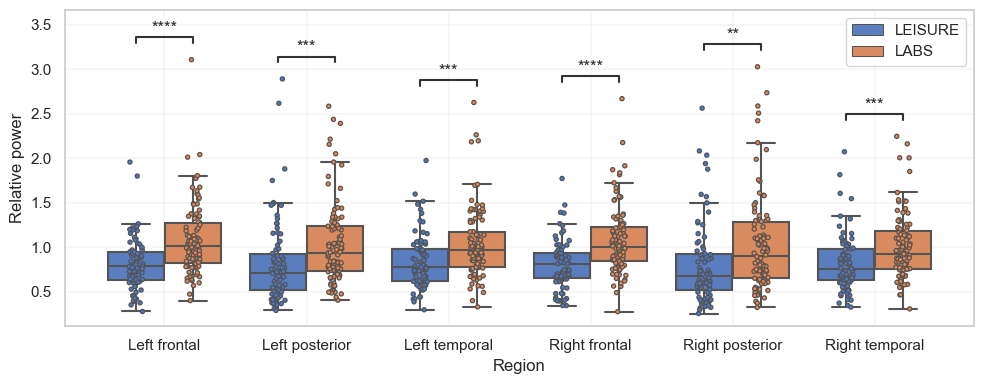

In [23]:
post_hoc = 'Bonferroni'
measure = 'Theta relative power'

# Create a dataframe for the measure of interest
df_powers = df_wo_bads[[measure, 'Region', 'Group']]

# Run stats for all the regions
df_stats = pd.DataFrame()
for i, region in enumerate(df_wo_bads['Region'].unique()):
    # Do Mann-Whitney U test (non-parametric, independent groups) between two groups
    df_powers_reg = df_powers[df_powers['Region']==region].drop(columns=['Region'])
    stats = pg.mwu(df_powers_reg[df_powers_reg['Group']==exp_condition[0]][measure],
                   df_powers_reg[df_powers_reg['Group']==exp_condition[1]][measure])

    # Apply Bonferroni post-hoc multiple comparisons correction
    if post_hoc == 'Bonferroni':
        stats['p-val'] = stats['p-val']*len(df_wo_bads['Region'].unique())
        stats['Post-hoc'] = post_hoc
    else:
        stats['Post-hoc'] = 'N/A'
    
    stats['Groups'] = str(exp_condition)
    stats['Region'] = region
    stats['Measure'] = measure

    df_stats = pd.concat([df_stats, stats])
display(df_stats)

swarm_kwargs = {'edgecolor' : 'gray', 'size' : 3, 'linewidth' : 0.9}
sns.set_context('notebook')
sns.set_palette('muted')
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
sns.boxplot(ax=axs, data=df_powers,
            x='Region', y=measure, hue='Group', showfliers=False,
            flierprops=dict(markerfacecolor = '0.5', markersize = 1))
sns.stripplot(ax=axs, data=df_powers, x='Region', y=measure, hue='Group',
              dodge=True, **swarm_kwargs)
axs.set_yscale('linear')
axs.grid(linewidth=0.2)
axs.set_xlabel('Region')
axs.set_ylabel('Relative power')
pairs=[
    (('Left frontal', 'LEISURE'), ('Left frontal', 'LABS')),
    (('Left posterior', 'LEISURE'), ('Left posterior', 'LABS')),
    (('Left temporal', 'LEISURE'), ('Left temporal', 'LABS')),
    (('Right frontal', 'LEISURE'), ('Right frontal', 'LABS')),
    (('Right posterior', 'LEISURE'), ('Right posterior', 'LABS')),
    (('Right temporal', 'LEISURE'), ('Right temporal', 'LABS'))]
annotator = Annotator(axs, pairs=pairs, data=df_powers, x='Region', y=measure, hue='Group',
                          plot="boxplot")\
                .configure(test=None, text_format='star',loc='inside', verbose=1)\
                .set_pvalues(pvalues=df_stats['p-val']).annotate()

if plot_titles==True: (axs[1].set_title('Theta relative band power'))
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles[0:2], labels[0:2])
plt.tight_layout()
if savefig == True:
    plt.savefig(fname='{}/relative_theta.png'.format(savefinal_folder), dpi=300)
plt.show()

In [ ]:
# ### Discontinued: joint plot with scatterplot and pointplots for exponent and offset

# df_aps_reg = df_aps[df_aps['Region']=='Left frontal']

# point_kwargs = {'markers' : ["o", "o"], 'linestyles' : [" ", " "], 'errwidth' : 2,
#                 'capsize' : 0.1}

# g = sns.JointGrid()
# x, y = df_aps_reg['Offset'], df_aps_reg['Exponent']
# sns.regplot(ax=g.ax_joint, data=df_aps_reg[df_aps_reg['Group']=='LEISURE'], x='Offset', y='Exponent',
#                 fit_reg=False, ci=None)
# sns.regplot(ax=g.ax_joint, data=df_aps_reg[df_aps_reg['Group']=='LABS'], x='Offset', y='Exponent',
#                 fit_reg=False, ci=None)
# sns.regplot(ax=g.ax_joint, data=df_aps_reg, x='Offset', y='Exponent', scatter=False,
#                 ci=None, color='gray', line_kws=dict(linestyle='--'))
# sns.pointplot(data=df_aps_reg, x='Offset', y='Region', hue='Group', dodge=0.3, ax=g.ax_marg_x, errorbar='sd', **point_kwargs)
# sns.pointplot(data=df_aps_reg, y='Exponent', x='Region', hue='Group', dodge=0.3, ax=g.ax_marg_y, errorbar='sd', **point_kwargs)